Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In [ ]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [ ]:
num_classes = len(id_map.keys())

Preprocessing Data

In [ ]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

In [ ]:
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

Train Test split data

In [ ]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset("/content/drive/MyDrive/Footpath Guidance System/archive/cityscapes_data/cityscapes_data/train", "/content/drive/MyDrive/Footpath Guidance System/archive/cityscapes_data/cityscapes_data/val")

100%|██████████| 500/500 [46:45<00:00,  5.61s/it]


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

Model Building

In [ ]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection
    
    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)
    
    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection
    
    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)
    
    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection
    
    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)
    
    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)
    
    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [ ]:
model = get_unet_model()

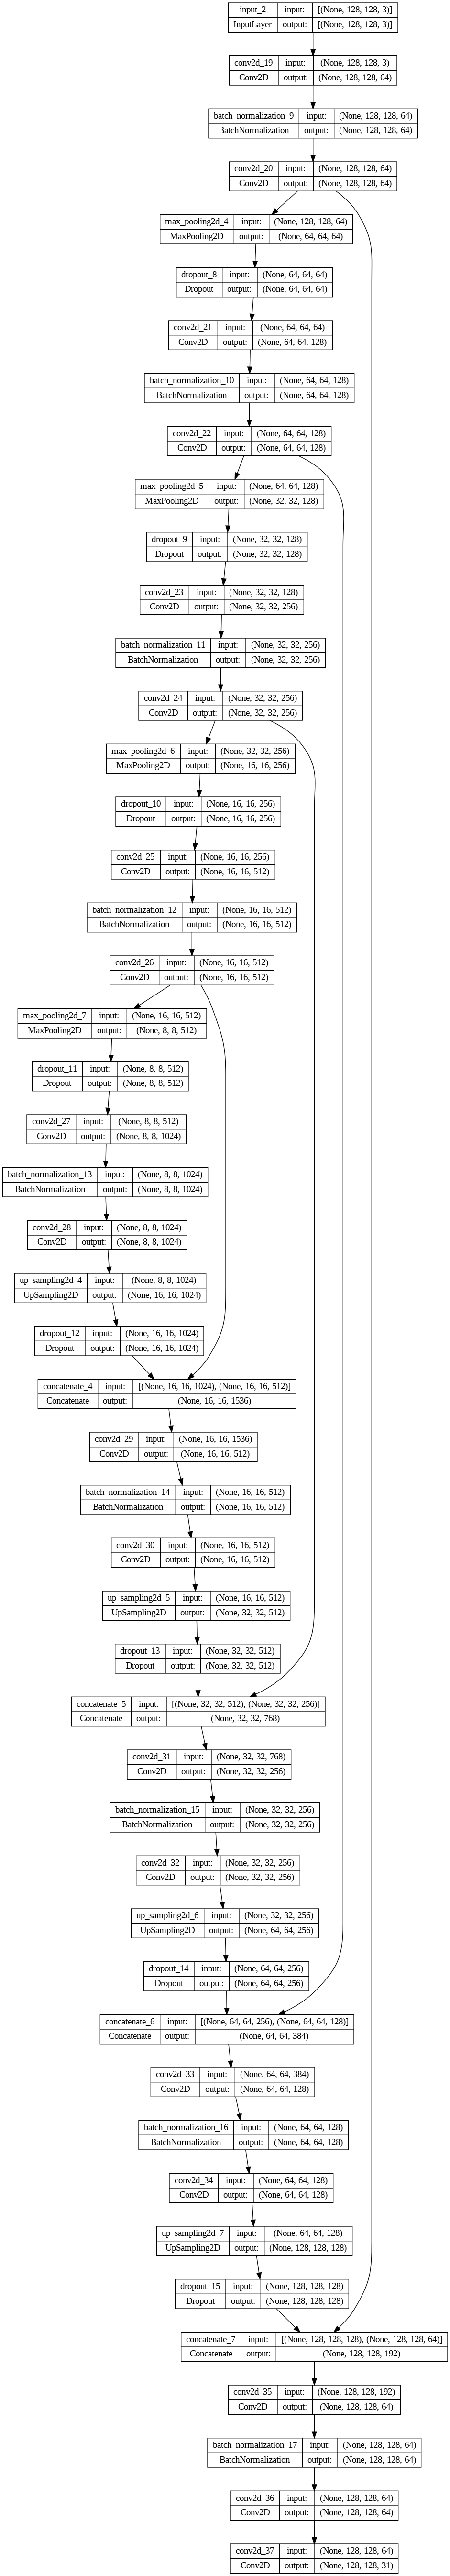

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("/content/drive/MyDrive/Footpath Guidance System/archive/cityscapes_data/cityscapes_data/val/106.jpg")

1/1 [==============================] - 1s 975ms/step


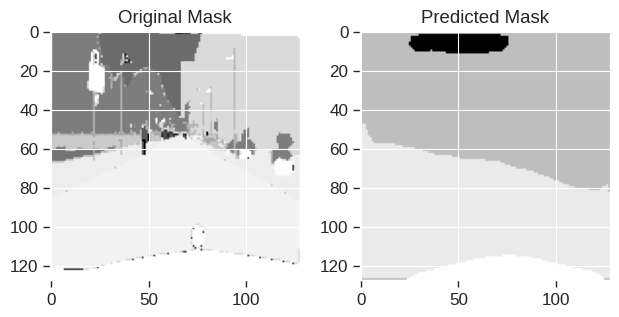

93/93 [==============================] - 7699s 83s/step - loss: 0.8260 - accuracy: 0.7766 - mean_iou: 0.1991 - val_loss: 1.8754 - val_accuracy: 0.5371 - val_mean_iou: 0.0627


In [ ]:
history = model.fit(x=X_train, y=Y_train, epochs = 1, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid), callbacks=[early_stopping, viz_callback])
model.save('model.h5')